In [1]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [2]:
num_epochs = 4
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [4]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [5]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [6]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [7]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

Failed to download (trying next):
HTTP Error 403: Forbidden



9913344it [00:00, 15119236.42it/s]                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



29696it [00:00, 1026970.40it/s]          


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



1649664it [00:00, 7087789.56it/s]                             


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



5120it [00:00, 1711551.48it/s]          


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



# Train

In [10]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [35]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))
    for task in [0, 1, 2, 3, 4]:
        plt.subplot(2, 3, task+1)
        task_history = []
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                
        plt.plot(task_history, '-', label=f'Task {task}')

        plt.title(f'Accuracy per Mini-Batch for Task {task}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()


## Distribution Loss

In [23]:
def train_distribution(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            except_mean = 0.1
            empty_loss = 0
            for task in range (10):
                task_start = task
                task_end = (task + 1)

                fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                fake_output = follower(fake_image)

                real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                empty_loss += torch.abs(except_mean - real_mean)
            

            loss = criterion(outputs[:,:valid_out_dim], labels) + empty_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1


        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [24]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_0 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_distribution(model, task, criterion, 5)
    all_accuracies_0.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 4.6716, Task avg acc:4.6716
Task 0 acc: 19.7624, Task avg acc:19.7624
Task 0 acc: 35.6346, Task avg acc:35.6346
Task 0 acc: 46.5242, Task avg acc:46.5242
Task 0 acc: 55.1578, Task avg acc:55.1578
Task 0 acc: 60.5548, Task avg acc:60.5548
Task 0 acc: 63.6001, Task avg acc:63.6001
Task 0 acc: 68.4232, Task avg acc:68.4232
Task 0 acc: 69.7226, Task avg acc:69.7226
Task 0 acc: 71.0858, Task avg acc:71.0858
Task 0 acc: 73.1186, Task avg acc:73.1186
Task 0 acc: 74.0354, Task avg acc:74.0354
Task 0 acc: 74.2188, Task avg acc:74.2188
Task 0 acc: 74.0832, Task avg acc:74.0832
Task 0 acc: 74.9841, Task avg acc:74.9841
Task 0 acc: 75.8689, Task avg acc:75.8689
Task 0 acc: 75.9247, Task avg acc:75.9247
Task 0 acc: 75.7015, Task avg acc:75.7015
Task 0 acc: 76.1001, Task avg acc:76.1001
Task 0 acc: 77.2959, Task avg acc:77.2959
Task 0 acc: 78.1728, Task avg acc:78.1728
Task 0 acc: 78.4837, Task avg acc:78.4837
Task 0 acc: 79.2650, Task avg acc:79.2650
T

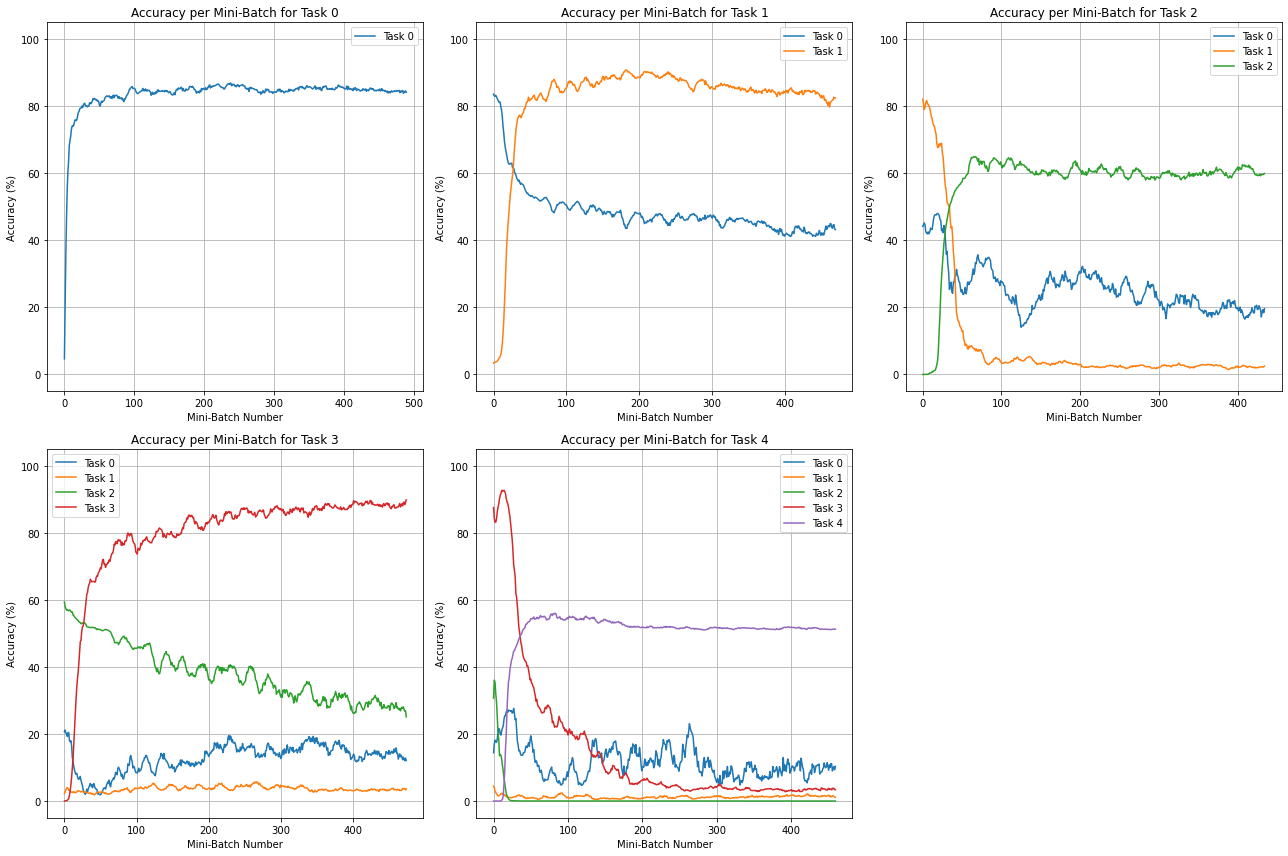

In [36]:
plot_acc_history(all_accuracies_0)

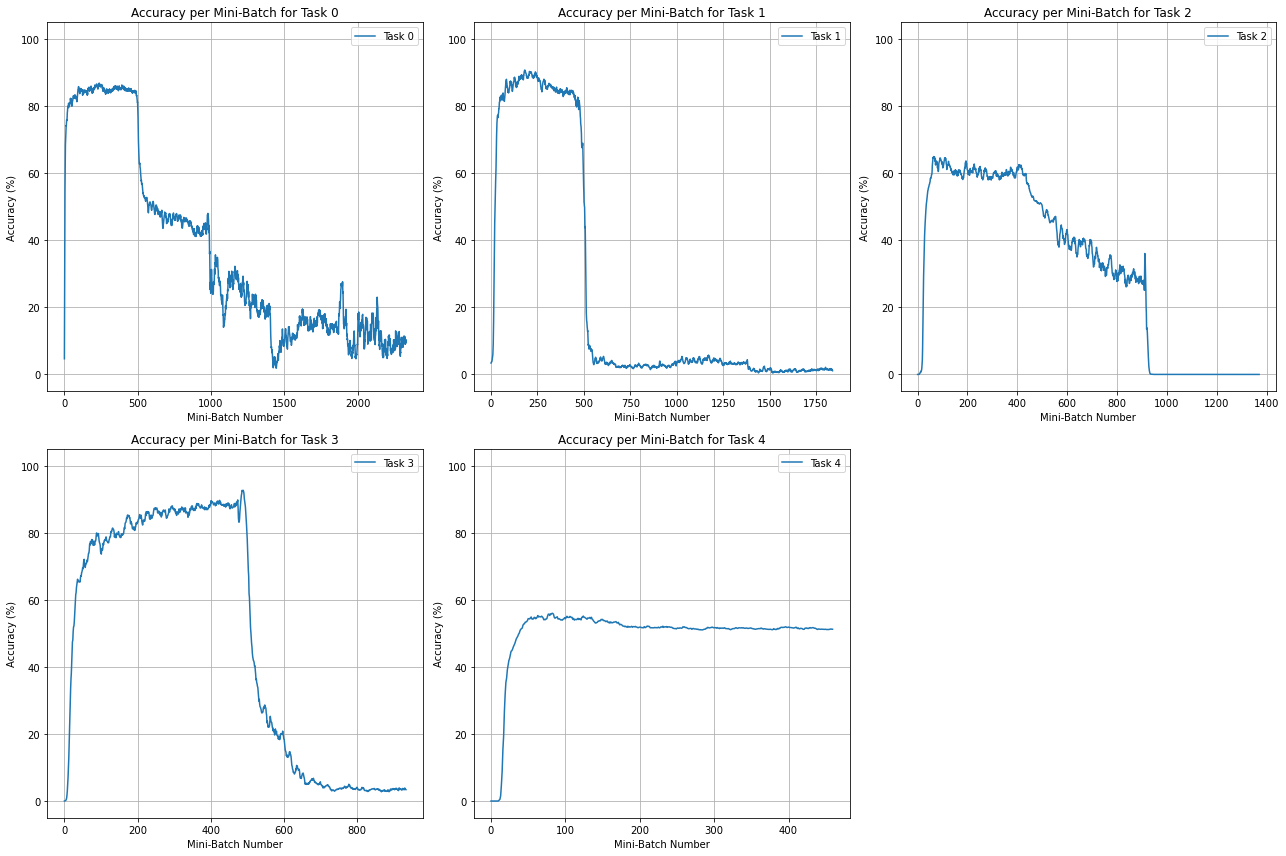

In [37]:
plot_task_acc_history(all_accuracies_0)


## Distribution Loss II

In [54]:
def train_distribution_II(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            loss = criterion(outputs[:,:valid_out_dim], labels)

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            except_mean = 0.1
            empty_loss = 0
            for task in range (10):
                task_start = task
                task_end = (task + 1)

                fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                fake_output = follower(fake_image)

                real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                empty_loss += torch.abs(except_mean - real_mean)
            
            loss = 0.1 * empty_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1


        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [55]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_4 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_distribution_II(model, task, criterion, 5)
    all_accuracies_4.append(accuracies)

##########Task 0##########
Epoch 0
Batch num: 0, Task 0 acc: 36.0491, Task avg acc:36.0491
Batch num: 10, Task 0 acc: 84.1518, Task avg acc:84.1518
Batch num: 20, Task 0 acc: 85.0765, Task avg acc:85.0765
Batch num: 30, Task 0 acc: 87.4681, Task avg acc:87.4681
Batch num: 40, Task 0 acc: 87.6834, Task avg acc:87.6834
Batch num: 50, Task 0 acc: 88.1856, Task avg acc:88.1856
Batch num: 60, Task 0 acc: 87.2210, Task avg acc:87.2210
Batch num: 70, Task 0 acc: 88.7835, Task avg acc:88.7835
Batch num: 80, Task 0 acc: 85.8020, Task avg acc:85.8020
Batch num: 90, Task 0 acc: 85.3077, Task avg acc:85.3077
Epoch 1
Batch num: 0, Task 0 acc: 86.2085, Task avg acc:86.2085
Batch num: 10, Task 0 acc: 86.8543, Task avg acc:86.8543
Batch num: 20, Task 0 acc: 87.2768, Task avg acc:87.2768
Batch num: 30, Task 0 acc: 88.8473, Task avg acc:88.8473
Batch num: 40, Task 0 acc: 90.0510, Task avg acc:90.0510


In [ ]:
plot_acc_history(all_accuracies_4)

In [ ]:
plot_task_acc_history(all_accuracies_4)

## Forward Task Loss

In [18]:
def train_forward_task(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)


            with torch.no_grad():
                leader_output = model(images)

            if (task_num == 0):
                diff_loss =  0
            else:
                diff_loss =  2 * torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))

            loss = criterion(outputs[:,:valid_out_dim], labels) + diff_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1

        adjust_learning_rate(optimizer_F)

    
    return follower, task_accuracies

In [19]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_1 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_forward_task(model, task, criterion, 5)
    all_accuracies_1.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 99.9442, Task avg acc:99.9442
Epoch 1
Task 0 acc: 99.9601, Task avg acc:99.9601
Epoch 2
Task 0 acc: 99.9601, Task avg acc:99.9601
Epoch 3
Task 0 acc: 99.9841, Task avg acc:99.9841
Epoch 4
Task 0 acc: 99.9841, Task avg acc:99.9841
##########Task 1##########
Epoch 0
Task 0 acc: 99.8166, Task 1 acc: 55.3856, Task avg acc:77.6011
Epoch 1
Task 0 acc: 99.5855, Task 1 acc: 59.1922, Task avg acc:79.3888
Epoch 2
Task 0 acc: 98.3658, Task 1 acc: 66.9880, Task avg acc:82.6769
Epoch 3
Task 0 acc: 98.5172, Task 1 acc: 62.3255, Task avg acc:80.4213
Epoch 4
Task 0 acc: 95.6712, Task 1 acc: 67.7693, Task avg acc:81.7203
##########Task 2##########
Epoch 0
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 99.3265, Task avg acc:33.1088
Epoch 1
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 99.7396, Task avg acc:33.2465
Epoch 2
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 99.8294, Task avg acc:33.2765
Epoch 3
Task 0 acc: 0.0000, Task 1 acc: 0.00

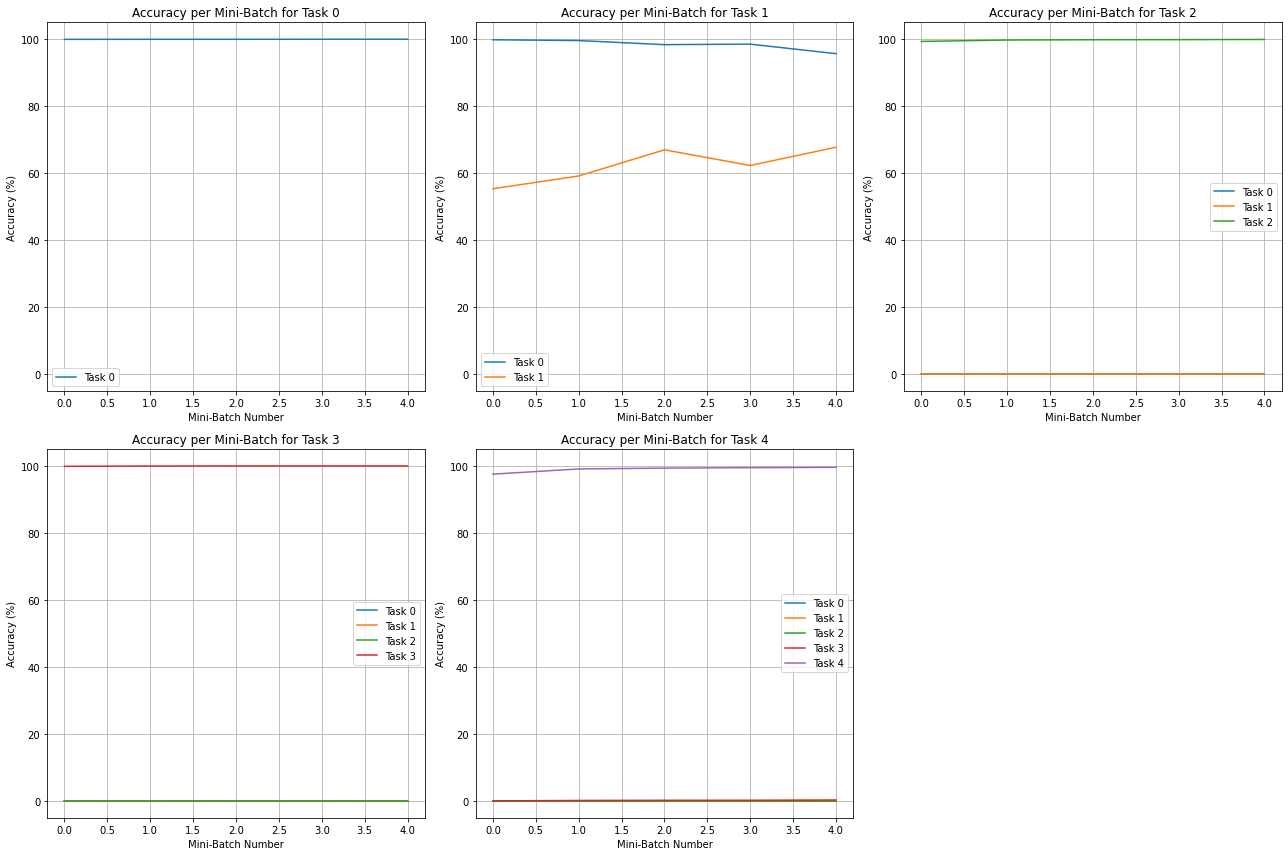

In [38]:
plot_acc_history(all_accuracies_1)

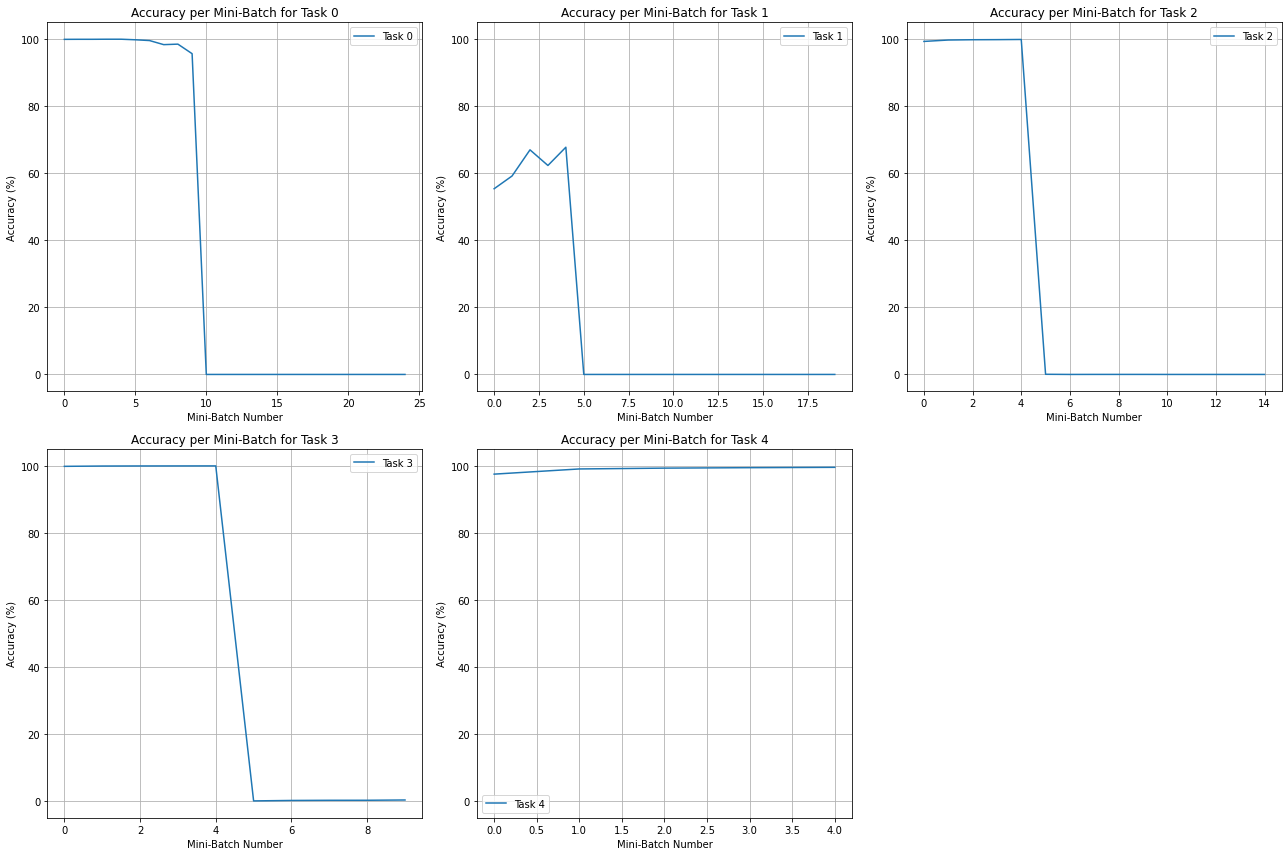

In [39]:
plot_task_acc_history(all_accuracies_1)

## Interupt Loss

In [82]:
def train_interupt(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            interupt_loss = 0
            for i in range (4):
                fake_image = torch.randn(batch_size, 1, 28, 28)

                with torch.no_grad():
                    leader_fake_output = model(fake_image)
                
                fake_outputs = follower(images)

                if (task_num == 0):
                    interupt_loss =  0
                else:
                    interupt_loss += torch.mean(torch.abs(leader_fake_output - fake_outputs))

            loss = criterion(outputs[:,:valid_out_dim], labels) + 0.65 * interupt_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1

        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [83]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_3 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_interupt(model, task, criterion, 5)
    all_accuracies_3.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 1
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 2
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 3
Task 0 acc: 99.9681, Task avg acc:99.9681
Epoch 4
Task 0 acc: 99.9681, Task avg acc:99.9681
##########Task 1##########
Epoch 0
Task 0 acc: 1.6183, Task 1 acc: 98.0136, Task avg acc:49.8160
Epoch 1
Task 0 acc: 1.2277, Task 1 acc: 98.8198, Task avg acc:50.0237
Epoch 2
Task 0 acc: 0.7653, Task 1 acc: 99.0858, Task avg acc:49.9255
Epoch 3
Task 0 acc: 0.5580, Task 1 acc: 99.2686, Task avg acc:49.9133
Epoch 4
Task 0 acc: 0.7175, Task 1 acc: 99.3517, Task avg acc:50.0346
##########Task 2##########
Epoch 0
Task 0 acc: 0.0000, Task 1 acc: 1.2217, Task 2 acc: 99.1290, Task avg acc:33.4502
Epoch 1
Task 0 acc: 0.0000, Task 1 acc: 0.4904, Task 2 acc: 99.6049, Task avg acc:33.3651
Epoch 2
Task 0 acc: 0.0000, Task 1 acc: 0.4156, Task 2 acc: 99.7216, Task avg acc:33.3791
Epoch 3
Task 0 acc: 0.0000, Task 1 acc: 0.4654, T

In [40]:
plot_acc_history(all_accuracies_3)

NameError: name 'all_accuracies_3' is not defined

In [41]:
plot_task_acc_history(all_accuracies_3)

NameError: name 'all_accuracies_3' is not defined